In [2]:
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK
from scipy.stats import chi2_contingency
from tqdm import tqdm
from scipy.stats import wilcoxon
from drn_interactions.stats import mannwhitneyu_plusplus
import pingouin as pg
from scipy.stats import spearmanr

fig_dir = Config.fig_dir
sns.set_theme(style="ticks", context="paper")

In [4]:
def load_responders():
    slow_responders_shock = load_derived_generic(
        "slow_ts_foot_shock_unit_responders_pre_to_shock.csv"
    )[["neuron_id", "diff_inv", "sig"]].assign(
        response_fs_slow=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["diff_inv"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_slow"]]

    fast_responders = load_derived_generic("fast_fs_foot_shock_unit_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_fs_fast=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_fast"]]
    df_responders = pd.merge(slow_responders_shock, fast_responders, on="neuron_id", how="outer")
    return df_responders
    

In [18]:
sessions = ExperimentInfo.foot_shock_sessions_10min
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
df_distance = load_distances()
df_ensembles = load_derived_generic("ensembles/fs - ensembles.csv").drop_duplicates().query("bin_width == 1")
df_ensembles["in_ensemble"] = np.where(df_ensembles["ensemble_id"] != "-1", True, False)
df_responders = load_responders()

graph_attrs = GraphAttributes(inverse_distance=True)
node_attrs = NodeAttributes()

graph_dfs = []
node_dfs = []
edge_dfs = []

for bin_width in tqdm((0.05, 0.1, 0.5, 1)):
    for block in ("pre", "base_shock"):
        g_transformer = GraphTransformer(
            relabel_nodes=True,
            weight_attr="weight",
            neuron_types=neuron_types,
            df_distance=df_distance,
            df_ensemble=df_ensembles.loc[
                (df_ensembles["block"] == block)
                & (df_ensembles["bin_width"] == bin_width)
            ],
        )
        for session in sessions:
            loader = BaseShockSlowInteractionsLoader(
                session_name=session,
                bin_width=bin_width,
                block=block,
            )
            preprocessor = InteractionsPreprocessor()
            pairwise = PairwiseCorr(rectify=True, shuffle=False)

            spikes = preprocessor(loader())
            df_affinity = (
                pairwise.fit(spikes)
                .get_adjacency_df()
                .dropna(axis=1, thresh=5)
                .dropna(axis=0, thresh=5)
            )
            G = df_to_graph(df_affinity, rename_nodes=True)

            graph_stats = graph_attrs.get_graph_attributes(G)
            node_stats = node_attrs.get_node_attributes(G, node_name="neuron_id")
            edge_stats = g_transformer.graph_to_edge_df(G)

            graph_dfs.append(
                graph_stats.assign(session=session, block=block, bin_width=bin_width)
            )
            node_dfs.append(
                node_stats.assign(session=session, block=block, bin_width=bin_width)
            )
            edge_dfs.append(
                edge_stats.assign(session=session, block=block, bin_width=bin_width)
            )

df_graph = pd.concat(graph_dfs).reset_index(drop=True)
df_edge = pd.concat(edge_dfs).reset_index(drop=True)
df_node = (
    pd.concat(node_dfs)
    .reset_index(drop=True)
    .merge(neuron_types[["neuron_id", "neuron_type"]], how="left")
).drop_duplicates()
df_node = df_node.merge(
    df_ensembles[
        [
            "neuron_id",
            "in_ensemble",
            "block",
            "bin_width",
        ]
    ],
    on=["neuron_id", "block", "bin_width"],
    how="left",
).drop_duplicates()
df_node = df_node.merge(df_responders, on="neuron_id", how="left")


  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
 25%|██▌       | 1/4 [00:26<01:19, 26.59s/it]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
 50%|█████     | 2/4 [00:48<00:47, 23.90s/it]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
 75%|███████▌  | 3/4 [01:06<00:21, 21.30s/it]c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
100%|██████████| 4/4 [01:25<00:00, 21.35s/it]


In [19]:
dd = Config.derived_data_dir / "graph"

dd.mkdir(exist_ok=True)

df_graph.to_csv(dd / "fs - graph.csv", index=False)
df_node.to_csv(dd / "fs - node.csv", index=False)
df_edge.to_csv(dd / "fs - edge.csv", index=False)
df_responders.to_csv(dd / "fs - responders.csv", index=False)


### Graph Props

Does the structure of inactions change between SW and Act?

Metrics:
- Average Clustering
- Normalized Weight
- SWP

n_Pre         8.000000
n_Shock       8.000000
Mean_Pre      0.330482
Mean_Shock    0.543032
Diff          0.212550
U             7.000000
p             0.148438
dtype: float64


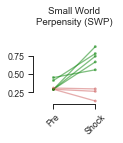

In [12]:
from scipy.stats import ttest_rel

def compare_graph(df, metric):
    piv = df.pivot(index="session", columns="block", values=metric)
    x = piv["Pre"]
    y = piv["Shock"] 
    res = mannwhitneyu_plusplus(x, y, names=("Pre", "Shock"), compare_f=wilcoxon)
    return res

def plot_graph(df, metric, ax=None, **kwargs):
    pg.plot_paired(df, dv=metric, within="block", subject="session", ax=ax, **kwargs)
    return 


dfg = (
    load_derived_generic("graph/fs - graph.csv")
    .loc[lambda x: x.bin_width == 1]
    .copy()
    .assign(block=lambda x: np.where(x.block == "pre", "Pre", "Shock"))
    .assign(block=lambda x: pd.Categorical(x.block, categories=["Pre", "Shock"]))
)


f = plt.figure(figsize=(1.5, 1.1))

ax = f.subplots()

print(compare_graph(dfg, "swp"))
plot_graph(dfg, "swp",  ax=ax, pointplot_kwargs=dict(alpha=0.5,), dpi=300,  boxplot=False)
ax.set_title("Small World\nPerpensity (SWP)", pad=20)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")


f.subplots_adjust(wspace=0.3)
# f.savefig(fig_dir / "fs - graph stats.png", bbox_inches="tight", dpi=300)

### Node Props

In [24]:

def node_correlate(df, metric):
    piv = (
        df
        [["neuron_id", "block", metric]]
        .drop_duplicates()
        .pivot(index="neuron_id", columns="block", values=metric)
        .dropna()
    )
    x = piv["Pre"]
    y = piv["Shock"]
    res = mannwhitneyu_plusplus(x, y, names=("Pre", "Shock"), compare_f=spearmanr).round(3)
    return res

dfn = (
    load_derived_generic("graph/fs - node.csv")
    .loc[lambda x: x.bin_width == 1]
    .copy()
    .assign(block=lambda x: np.where(x.block == "pre", "Pre", "Shock"))
    .assign(block=lambda x: pd.Categorical(x.block, categories=["Pre", "Shock"]))
)


print("degree\n", node_correlate(dfn, "degree"))
print("\nclust\n", node_correlate(dfn, "clust"))

degree
 n_Pre         258.000
n_Shock       258.000
Mean_Pre        0.156
Mean_Shock      0.082
Diff           -0.074
U               0.331
p               0.000
dtype: float64

clust
 n_Pre         258.000
n_Shock       258.000
Mean_Pre        0.208
Mean_Shock      0.135
Diff           -0.073
U               0.266
p               0.000
dtype: float64


In [25]:
def edge_correlate(df, metric):
    piv = (
        df
        [["comb_id", "block", metric]]
        .drop_duplicates()
        .pivot(index="comb_id", columns="block", values=metric)
        .dropna()
    )
    x = piv["Pre"]
    y = piv["Shock"]
    res = mannwhitneyu_plusplus(x, y, names=("Pre", "Shock"), compare_f=spearmanr).round(3)
    return res

dfe = (
    load_derived_generic("graph/fs - edge.csv")
    .loc[lambda x: x.bin_width == 1]
    .copy()
    .assign(block=lambda x: np.where(x.block == "pre", "Pre", "Shock"))
    .assign(block=lambda x: pd.Categorical(x.block, categories=["Pre", "Shock"]))
)

print(edge_correlate(dfe, "weight"))

n_Pre         2044.000
n_Shock       2044.000
Mean_Pre         0.258
Mean_Shock       0.137
Diff            -0.121
U                0.190
p                0.000
dtype: float64
